# Momentum Trading Strategy
This strategy will compare the short-term changes in a stock to longer term trends to determine buy and sell signals. We chose 5-day and 20-day simple moving averages, representing 1-week and 4-week trends (excluding non-trading days), determining buy and sell signals based on whether the more recent growth surpasses the longer term trend.

In [10]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

### Downloading ETF Data:
We are using the Gold ETF; this strategy is motivated by a desire to beat a stable benchmark stock. Our other considerations were SPY and VOO.

In [11]:
gld = yf.download('GLD', start = '2020-01-01', end = None, auto_adjust = True)
gld.drop(columns=['Volume', 'Open', 'High', 'Low'], inplace = True)
gld.head()

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2020-01-02,143.949997
2020-01-03,145.860001
2020-01-06,147.389999
2020-01-07,147.970001
2020-01-08,146.860001


### Develop Position Signals
We are going to try a moving average crossover to generate signals for this strategy. We will always be "in" a trade, either long or short. First, we develope moving averages and add them into our dataframe; then, we add a signal column that is filled with 1 or -1 depending on which moving average is greater. We also add an entry column, showing when signals swing between our positions. Finally, we will evaluate our progress by adding a return and system return column; the return column is our benchmark, while the system return is representing how much gain or loss we experience depending on the position.

In [12]:
gld['5-day'] = gld['Close'].rolling(5).mean()
gld['20-day'] = gld['Close'].rolling(20).mean()
gld[19:25]

,Close,5-day,20-day
Date,,,
2020-01-30,148.470001,148.312003,146.906001
2020-01-31,149.330002,148.582004,147.175001
2020-02-03,148.360001,148.456003,147.300001
2020-02-04,146.429993,148.210001,147.252000
2020-02-05,146.610001,147.839999,147.184000
2020-02-06,147.399994,147.625998,147.211000


In [13]:
gld['signal'] = np.where(gld['5-day'] > gld['20-day'], 1, 0)
gld['signal'] = np.where(gld['5-day'] < gld['20-day'], -1, gld['signal'])
gld.dropna(inplace=True)
gld.head()

,Close,5-day,20-day,signal
Date,,,,
2020-01-30,148.470001,148.312003,146.906001,1
2020-01-31,149.330002,148.582004,147.175001,1
2020-02-03,148.360001,148.456003,147.300001,1
2020-02-04,146.429993,148.210001,147.252000,1
2020-02-05,146.610001,147.839999,147.184000,1


In [14]:
gld['return'] = np.log(gld['Close']).diff()
gld['system_return'] = gld['signal'] * gld['return']
gld['entry'] = gld.signal.diff()
gld.head(10)

,Close,5-day,20-day,signal,return,system_return,entry
Date,,,,,,,
2020-01-30,148.470001,148.312003,146.906001,1,NaN,NaN,NaN
2020-01-31,149.330002,148.582004,147.175001,1,0.005776,0.005776,0.0
2020-02-03,148.360001,148.456003,147.300001,1,-0.006517,-0.006517,0.0
2020-02-04,146.429993,148.210001,147.252000,1,-0.013094,-0.013094,0.0
2020-02-05,146.610001,147.839999,147.184000,1,0.001229,0.001229,0.0
2020-02-06,147.399994,147.625998,147.211000,1,0.005374,0.005374,0.0
2020-02-07,147.789993,147.317996,147.299000,1,0.002642,0.002642,0.0
2020-02-10,148.169998,147.279996,147.362000,-1,0.002568,-0.002568,-2.0
2020-02-11,147.660004,147.525998,147.453999,1,-0.003448,-0.003448,2.0


### Performance
Below is a visualization of our buy and sell signals. The green arrows mark the point of the short-term moving average surpassing the long-term one, and are buy signals. The red arrows mark the opposite.

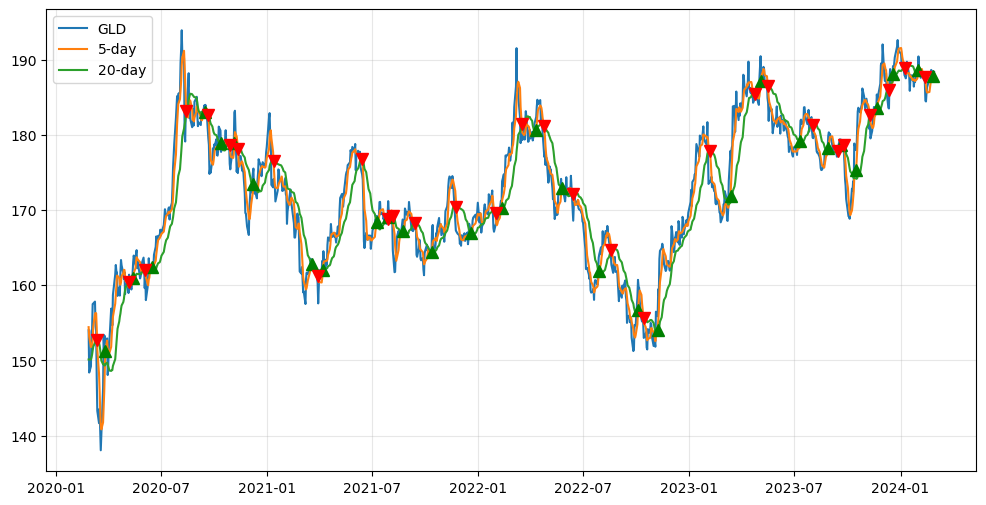

In [15]:
plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = .3)
plt.plot(gld.iloc[-1008:]['Close'], label = 'GLD')
plt.plot(gld.iloc[-1008:]['5-day'], label = '5-day')
plt.plot(gld.iloc[-1008:]['20-day'], label = '20-day')
plt.plot(gld[-1008:].loc[gld.entry == 2].index, gld[-1008:]['5-day'][gld.entry == 2], '^',
         color = 'g', markersize = 9)
plt.plot(gld[-1008:].loc[gld.entry == -2].index, gld[-1008:]['20-day'][gld.entry == -2], 'v',
         color = 'r', markersize = 9)
plt.legend();

And this is a visualization of our cumulative returns for the ETF if we had bought and held, versus the strategy we implemented.

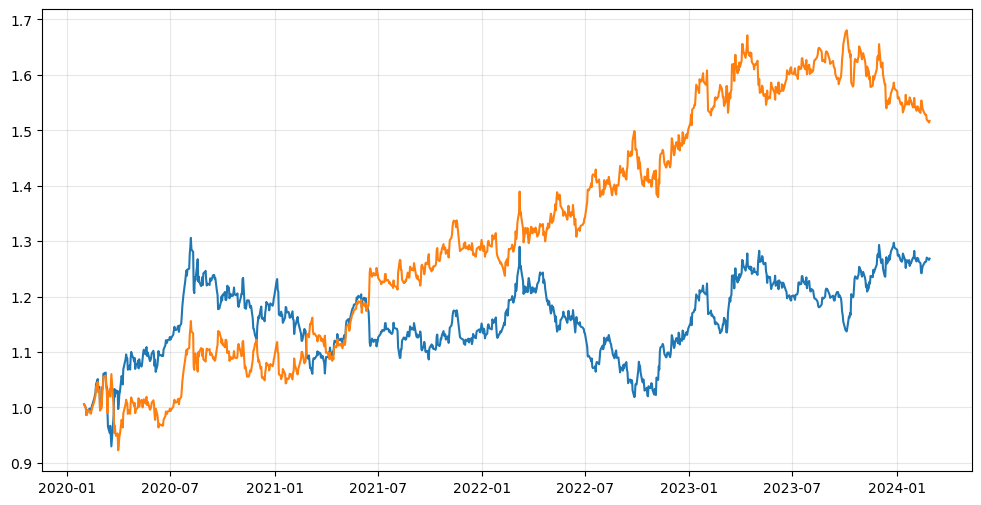

In [16]:
plt.plot(np.exp(gld['return']).cumprod(), label='Buy/Hold')
plt.plot(np.exp(gld['system_return']).cumprod(), label='Strategy')
plt.grid(True, alpha = .3)

Below is numerical data for the momentum strategy we developed and the benchmark: the strategy has a higher Sharpe ratio and cumulative return, meaning it would be a more attractive option and our strategy overperformed.

In [17]:
benchmark_return = np.exp(gld['return']).cumprod()[-1] -1
system_return = np.exp(gld['system_return']).cumprod()[-1] -1
benchmark_sharpe = (gld['return'].mean()/np.std(gld['return'])) * np.sqrt(252)
system_sharpe = (gld['system_return'].mean()/np.std(gld['system_return'])) * np.sqrt(252)

print('Benchmark Sharpe Ratio: ', benchmark_sharpe.round(2),
      '\nBenchmark Return: ', benchmark_return.round(2),
      '\nSystem Sharpe Ratio: ', system_sharpe.round(2),
      '\nSystem Return: ', system_return.round(2))

Benchmark Sharpe Ratio:  0.38 
Benchmark Return:  0.27 
System Sharpe Ratio:  0.66 
System Return:  0.52


#### Motivation
When considering a momentum strategy, we considered ETFs as they are stable long-term positions. Our strategy was motivated by a desire to outperform a stable, index-like stock. Our simple moving average ranges were based on 1-week and 1-month trading days, as with an ETF we didn't want our ranges to be too long as that could lead to too few buy/sell points as the stock is lacking volatility.

#### Analysis
Our performance was good -- the returns of our strategy were 51% to the 27% of the benchmark (buying and holding). Buying and holding was a middling investment, with a Sharpe ratio of .37, but our strategy held a ratio of .66, which is not great despite the significant returns. Our strategy worked well most likely because of the stock we selected -- it isn't very volatile, so the SMA ranges we chose accurately represented a bigger trend in momentum. Our strategy's primary flaw is its inability to outperform the benchmark in times of high volatility, as seen in the data from 2020 during the pandemic. It could likely be improved with another condition for buy and sell signals representing how long a simple moving average stays above or below the threshold, rather than only its intersection. Transaction costs are likely to have a minimal impact on our strategy since we aren't making moves in a very high frequency.

#### References
https://www.investopedia.com/terms/m/momentum_investing.asp